## Theoretical Part

### 1) EXAMple Question - Roll the dice

\begin{align*}
    p(\theta|x) &= \frac{p(x|\theta)p(\theta)}{p(x)}\\
    &= \frac{Mul(x; N, \boldsymbol{\theta}) \cdot Dir(\boldsymbol{\alpha}, \boldsymbol{\theta})}{\int Mul(x; N, \boldsymbol{\theta}) \cdot Dir(\boldsymbol{\alpha}, \boldsymbol{\theta})\hspace{0.2cm} d\boldsymbol{\theta}}\\
    &= \frac{\frac{N!}{\prod_{i=1}^6 x_i!}\prod_{i=1}^6 \theta_{i}^{x_i} \cdot \frac{1}{B(\boldsymbol{\alpha})} \prod_{i=1}^6 \theta_i^{\alpha_i} - 1}{\int Mul(x; N, \boldsymbol{\theta}) \cdot Dir(\boldsymbol{\alpha}, \boldsymbol{\theta})\hspace{0.2cm} d\boldsymbol{\theta}}\\
    &= \frac{N! \cdot \prod_{i=1}^6 \theta_{i}^{x_i}(\theta_i^{\alpha_i} - 1)}{\prod_{i=1}^6 x_i! \cdot B(\boldsymbol{\alpha}) \cdot p(x)}\\
\end{align*}

### 2) Theory Question - Gaussian posterior

(a)

We will show that $p(x^{*}|x) \propto p(x|x^{*})p(x^*)$.

\begin{align*}
p(x^{*}|x) &= \frac{exp(\frac{-1}{2 \frac{1}{\frac{1}{\sigma^2_0} + N}} \left(x^* - \frac{\sum_{i=1}^N x_i}{\frac{1}{\sigma^2_0} + N}) \right)}{\frac{1}{\frac{1}{\sigma^2_0} + N} \sqrt{2\pi}}\\
&\overset{\sigma^2_0 = 1}{\approx} \frac{(N+1) exp( - \frac{N+1}{2} (x^* - \frac{1}{N+1} \sum_{i=1}^N x_i)^2}{2\pi}\\
&\approx (N+1)\frac{ exp( - \frac{N+1}{2} (x^* - \hat{\mu}))}{2\pi}\\
&... (?)\\
&\propto \frac{exp(-\frac{1}{2} (x^* - x)^2 - \frac{1}{2\sigma^2_0} {x^*}^2)}{\sigma_0 2 \pi}\\
&= \frac{exp(-\frac{1}{2}(x - x^*)^2}{\sqrt{2}\pi} \cdot \frac{exp(-\frac{1}{2\sigma_0^2}{x^*}^2}{\sigma_0 \sqrt{2}\pi}\\
&= p(x|x^*)p(x^*)
\end{align*}

(b) TODO

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import dirichlet, entropy
import string
import gensim
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


# Modelling Trump tweets

In this exercise, we will create a simple model to generate a list of words representing a tweet. We will use Bayesian inference to infer the model parameters using tweets from ex-president Donald Trump. Samples from the posterior will represent "word frequencies" and can thus be visualized by a word cloud.
![image](https://i.ibb.co/cY6QbdF/plot.png)

Finally, we will investigate how sequentially incorporating more tweets in our model reduces the entropy of the resulting posterior distribution.

In [2]:
df = pd.read_csv("trump_tweets.csv", index_col=0)
df.head()

,date,tweet,tokens
0,2017-01-20 06:31,It all begins today! I will see you at 11:00 A...,"['begins', 'today', 'see', '1100', 'swearingin..."
1,2017-01-20 11:51,Today we are not merely transferring power fro...,"['today', 'merely', 'transferring', 'power', '..."
2,2017-01-20 11:51,"power from Washington, D.C. and giving it back...","['power', 'washington', 'c', 'giving', 'back',..."
3,2017-01-20 11:52,What truly matters is not which party controls...,"['truly', 'matters', 'party', 'controls', 'gov..."
4,2017-01-20 11:53,"January 20th 2017, will be remembered as the d...","['january', '20th', '2017', 'remembered', 'day..."


## Tweets as a bag of words

In this exercise, we will assume that a tweet can be expressed as a **bag of words** i.e. a list only containing relevant words (excluding e.g. stop words, punctuations and more). We assume that these words come from a **dictionary** of a fixed length $J$. 

To create a representative dictionary, we will use gensim to do this automatically.

In [3]:
J = 200 # Number of words in the dictionary

In [4]:
X_tokens = list(list(map(lambda x: eval(x), df.tokens)))
dictionary = gensim.corpora.Dictionary(X_tokens)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=J)

We can use the function "dictionary.doc2bow" to translate our tokens (i.e. a list of words) to a list of tuples $(i,j)$ where $i$ is the index of the word in the dictionary and $j$ are the counts of the word.

In [5]:
X_bow = [dictionary.doc2bow(x) for x in X_tokens]
df["index_counts"] = X_bow

In [6]:
# Remove tweets containing words that are not in the dictionary
df = df[df['index_counts'].map(lambda d: len(d)) > 0]
df.head()

,date,tweet,tokens,index_counts
0,2017-01-20 06:31,It all begins today! I will see you at 11:00 A...,"['begins', 'today', 'see', '1100', 'swearingin...","[(0, 1), (1, 1), (2, 1)]"
1,2017-01-20 11:51,Today we are not merely transferring power fro...,"['today', 'merely', 'transferring', 'power', '...","[(1, 1), (3, 1), (4, 2), (5, 2), (6, 1)]"
2,2017-01-20 11:51,"power from Washington, D.C. and giving it back...","['power', 'washington', 'c', 'giving', 'back',...","[(7, 1), (8, 1), (9, 1), (10, 1)]"
3,2017-01-20 11:52,What truly matters is not which party controls...,"['truly', 'matters', 'party', 'controls', 'gov...","[(6, 1), (9, 1), (11, 2)]"
4,2017-01-20 11:53,"January 20th 2017, will be remembered as the d...","['january', '20th', '2017', 'remembered', 'day...","[(9, 1), (12, 1), (13, 1)]"


In [7]:
N = len(df) 
print("number of valid tweets = " +str(N))

number of valid tweets = 20293


## Bayesian inference via conjugate multinomial dirichlet

We will assume that all tweets are generated as follows:
* Each tweet is independently and identically distributed. 
* A tweet is a list of $K_i$ words $w_{i} = (w_{i1}, ..., w_{iK_{i}})$ where each word is represented by the index in the dictionary $w_{ij} \in \{1, \dots, J\}$.
* Each word $w_{ij}$ is drawn independently from the dictionary with a unknown probability $\theta = (\theta_1, \dots, \theta_J)$.

The likelihood under these assumptions is naturally given by the *Multinomial distribution*
$$ p(w_i|\theta) = Mul(w_{i};K_i, \theta) = \frac{K_i!}{\prod_{j=1}^J x_{ij}!} \prod_{j=1}^J  \theta_{j}^{x_{ij}} $$
were $x_{ij}$ does represent the number of times the word with index $j$ appears in tweet $i$.

As you already saw in the first exercise of this sheet, a conjugate prior over $\theta$ is given by the Dirichlet distribution $ p(\theta) = Dir(\alpha)$. Thus the posterior distribution is also a Dirichlet distribution
$$ p(\theta|w_1, \dots, w_n) = Dir(\theta;\hat{\alpha}) \qquad  \hat{\alpha} = \left(\alpha_1 + \sum_{i=1}^n x_{i1}, \cdots, \alpha_J + \sum_{i=1}^n x_{iJ} \right)$$

### Exercise 1:

We will put all the word counts in a matrix to make the above calculation more convenient.

Compute a $X^{N \times J}$ matrix, which contains all the word counts for all tweets.
$$ x_{ij} = \text{ Number of times word with index j occurs in tweet i}$$

**Note**: In the dataframe, we already have a list of tuples containing the counts and index for each word.

In [8]:
# TODO Fill the matrix
X_matrix = np.zeros([N, J])

In [9]:
N,J

(20293, 200)

In [10]:
for i,(dfindex, value) in enumerate(df['index_counts'].items()):
    vec = np.zeros(shape=(J,))
    for index,count in value:
        vec[index] = count
    X_matrix[i,:] = vec

### Exercise 2

Below we have two priors with two different parameters $\alpha_1$ and $\alpha_2$. Draw three samples from the prior and visualize them using the 'plot_words' function.

**Hint**: To sample from a Dirichlet distribution, you can use 'np.random.dirichlet'.

In [11]:
def plot_words(theta):
    """ Given a vector of word frequencies, this function produces a nice wordcloud."""
    fig = plt.figure()
    token_freq = dict(zip(list(dictionary.token2id.keys()), theta))
    wordcloud = WordCloud(max_words=100).fit_words(token_freq)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [12]:
# Prior 
alpha_prior1 = np.ones(J)
alpha_prior2 = np.arange(J) + 1

theta_alpha1 = np.random.dirichlet(alpha_prior1, size=3)
theta_alpha2 = np.random.dirichlet(alpha_prior2, size=3)

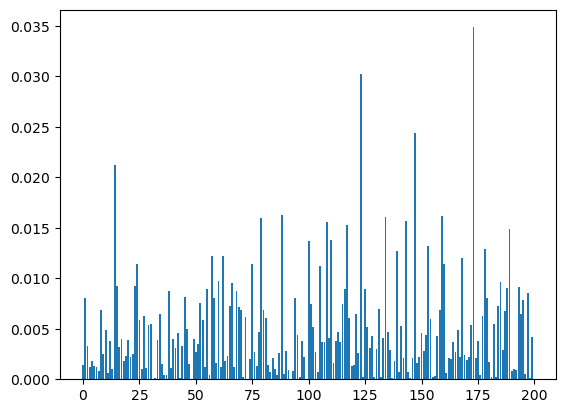

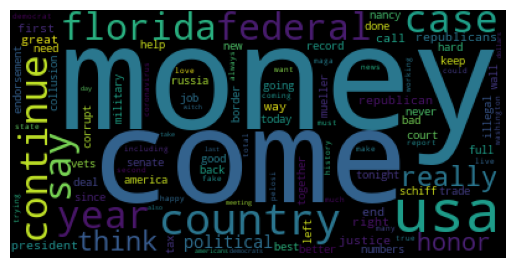

max word: money


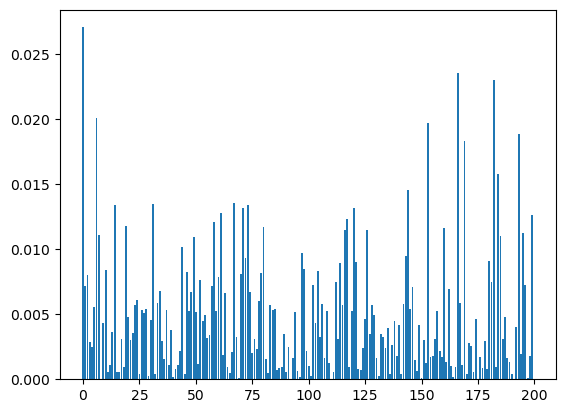

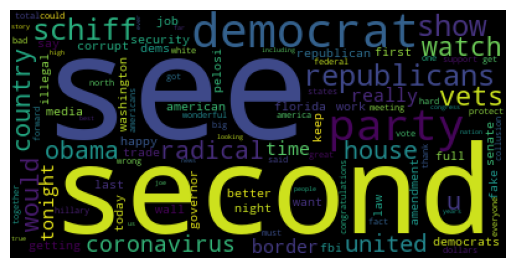

max word: see


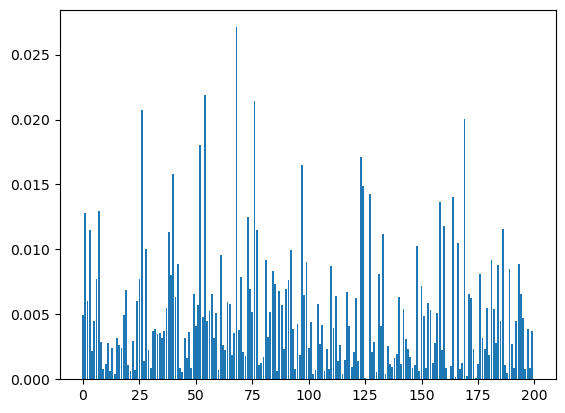

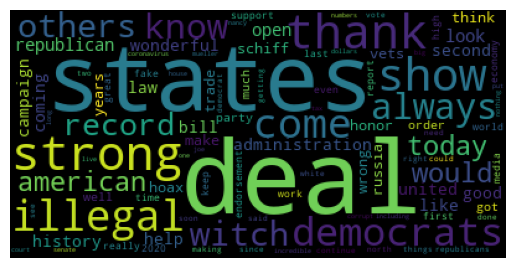

max word: deal


In [13]:

for th in theta_alpha1:
    plt.bar(range(J), th)
    plot_words(th)
    imax = np.argmax(th)
    print(f"max word: {dictionary.get(imax)}")

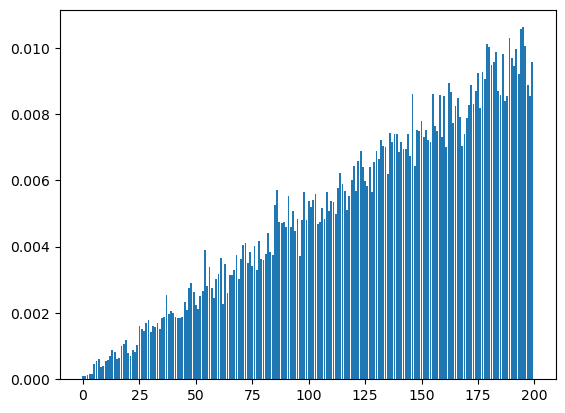

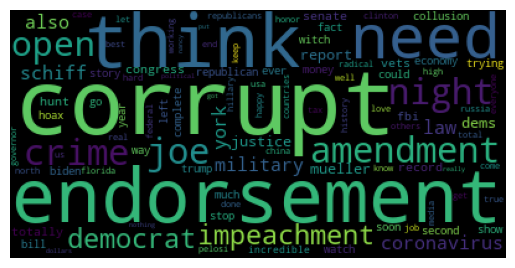

max word: corrupt


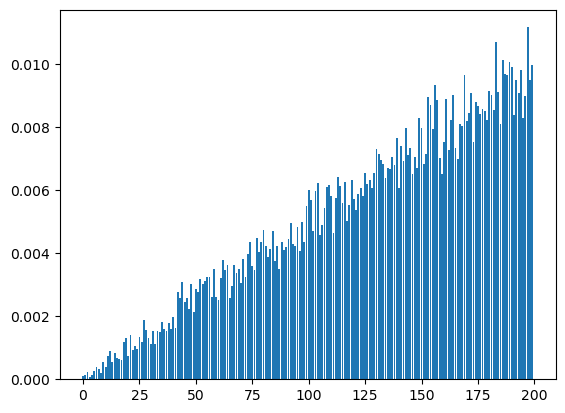

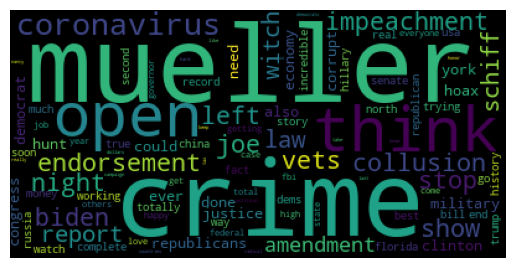

max word: mueller


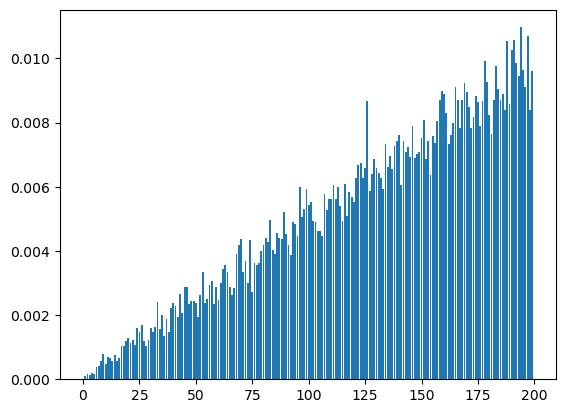

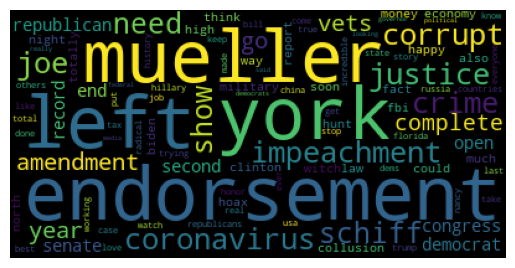

max word: endorsement


In [14]:

for th in theta_alpha2:
    plt.bar(range(J), th)
    plot_words(th)
    imax = np.argmax(th)
    print(f"max word: {dictionary.get(imax)}")



**Question**: What are the different underling prior assumptions of $\alpha_1$ and $\alpha_2$ for the data?

**Answer:** with $\boldsymbol{\alpha} = \{1,1,...,1\}$ the probability density function is a uniform distribution. For $\boldsymbol{\alpha} = \{1,2,3,...,J\}$ the distribution we obtain is heavily skewed towards the latter parts of the dictionary.

### Exercise 3

Compute the posterior distributions for both priors. This can be done efficiently using the matrix $X$ you just computed.

Plot some posterior samples as you did for the prior.

\begin{align*}
    p(x|\theta) &= \frac{p(\theta|x)p(\theta)}{p(x)}
\end{align*}

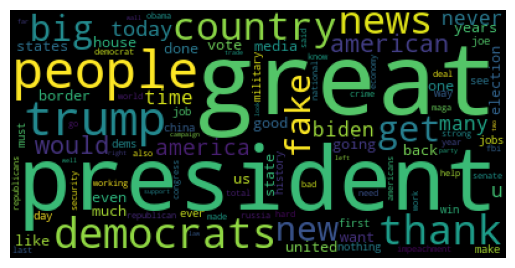

In [15]:
plot_words(np.random.dirichlet(np.cumsum(X_matrix, axis=0)[-1,:] + alpha_prior1))

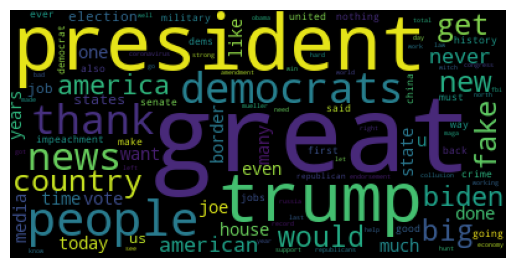

In [16]:
plot_words(np.random.dirichlet(np.cumsum(X_matrix, axis=0)[-1,:] + alpha_prior2))


**Question**: Do you see any difference? Explain why or why you don't see one.

**Answer**: As we update our belief about the frequencies of the words in our vocabulary with each tweet, the influence of our initial prior $\alpha$ diminishes. This becomes clear when we see, that even the two very different priors lead to the same posterior distribution of words.

### Exercise 4:

You learned in the lecture that we can also *sequentially update* the Bayesian posterior. So let's compute all sequentially updated posteriors, i.e., compute

$$ p(\theta| w_1), \ p(\theta| w_1, w_2), \ \dots ,  \ p(\theta| w_1, \dots, w_n)$$

You also learned about the **entropy** and **reduction in entropy**. So let's investigate how entropy changes.

* Compute the entropies i.e $H(\theta), H(\theta| w_1), H(\theta| w_1, w_2), \dots , H(\theta| w_1, \dots, w_n)$.
* Compute the reduction in entropies $ H(\theta| w_1) - H(\theta),  H(\theta| w_1, w_2) - H(\theta|w_1), \dots$.

**Note** You can use *dirichlet.entropy* to compute the entropies.

In [17]:
# Bayesian updating
alpha_post_sequential1 = list(map(np.random.dirichlet, np.cumsum(X_matrix, axis=0) + alpha_prior1.reshape(1, J)))
alpha_post_sequential2 = list(map(np.random.dirichlet, np.cumsum(X_matrix, axis=0) + alpha_prior2.reshape(1, J)))

In [18]:
entropies1 = entropy(alpha_post_sequential1, axis=1)
entropies2 = entropy(alpha_post_sequential2, axis=1)

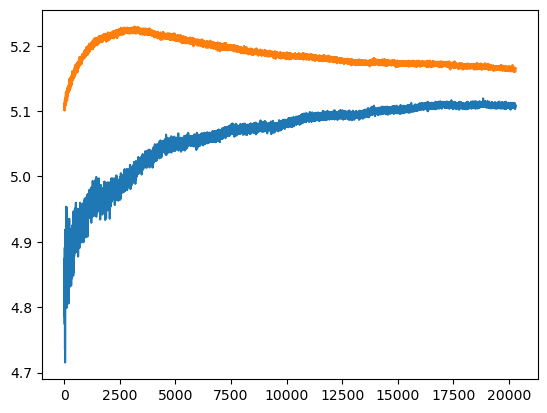

In [19]:
plt.plot(entropies1)
plt.plot(entropies2)

In [20]:
reduction_in_entropy1 = entropies1[1:] - entropies1[:-1]
reduction_in_entropy2 = entropies2[1:] - entropies2[:-1]

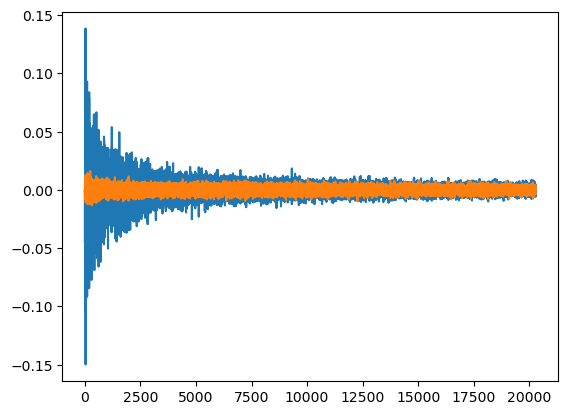

In [21]:
plt.plot(reduction_in_entropy1)
plt.plot(reduction_in_entropy2)


*Question*: Some tweets increase the entropy, why could this be?

**Answer**: When entropy is increased, it means that our distribution of word frequencies is converging towards a uniform distribution. A tweet containing low-frequency words for example might balance the overall frequencies out.

*Question*: Criticise the model. Point out at least two assumptions that the data likely does not satisfy

**Answer**: Probably the first flaw that comes to mind is the assumption, that the words found in a tweet are independent of each other, which is not true. The probability of a specific word appearing is highly dependant on the words preceding it. Additionally, the probability of observing a word $w_i$ is dependant on the time the tweet was tweeted. The word "snow" is unlikely to appear in a summer-time tweet.